# <center>CMSC320 - Final Project (need better title)</center>
<center>Michael Reeve and Sambit Sahoo</center>

## <center>Introduction</center>





In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date as dt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michael/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("cleandata.csv")
df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!


In [4]:
df = df.rename(columns={"Date": "DateTime"})
df["Date"] = pd.to_datetime(df["DateTime"]).dt.date
df.head()

,Tweets,Retweets,Likes,DateTime,Cleaned_Tweets,Date
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks,2022-10-27
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely,2022-10-27
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers,2022-10-27
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!,2022-10-26
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!,2022-10-26


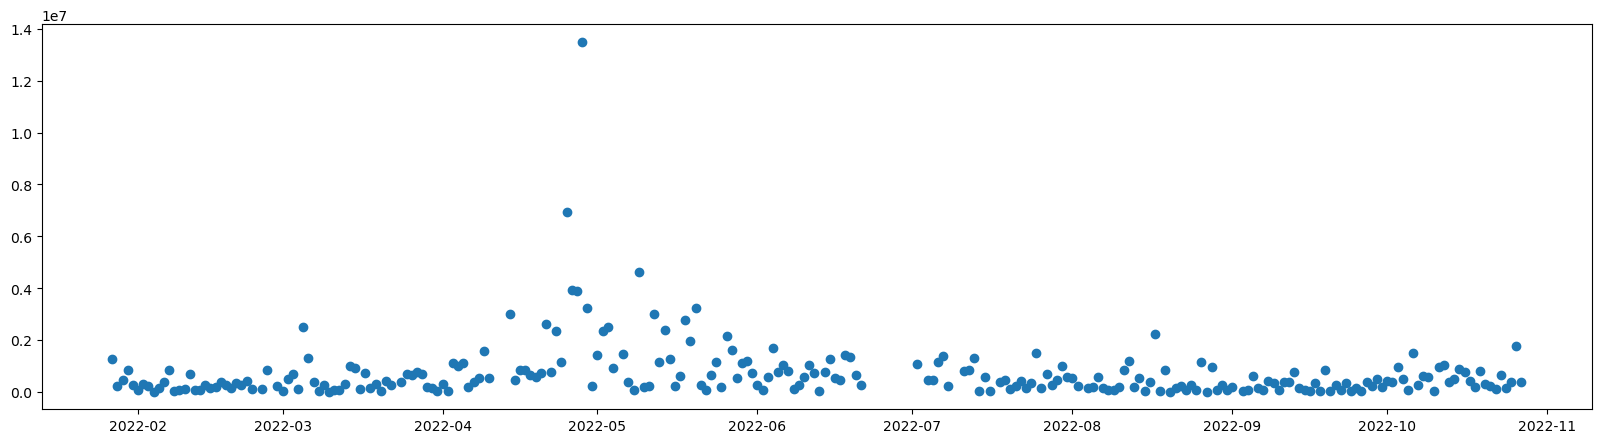

In [5]:
# likes per day
dates_sum_group = df.groupby(by="Date", as_index=False).sum()
# dates_group.plot.scatter(x="Date", y="Likes")
plt.figure(figsize=(20,5))
plt.scatter(dates_sum_group["Date"], dates_sum_group["Likes"])

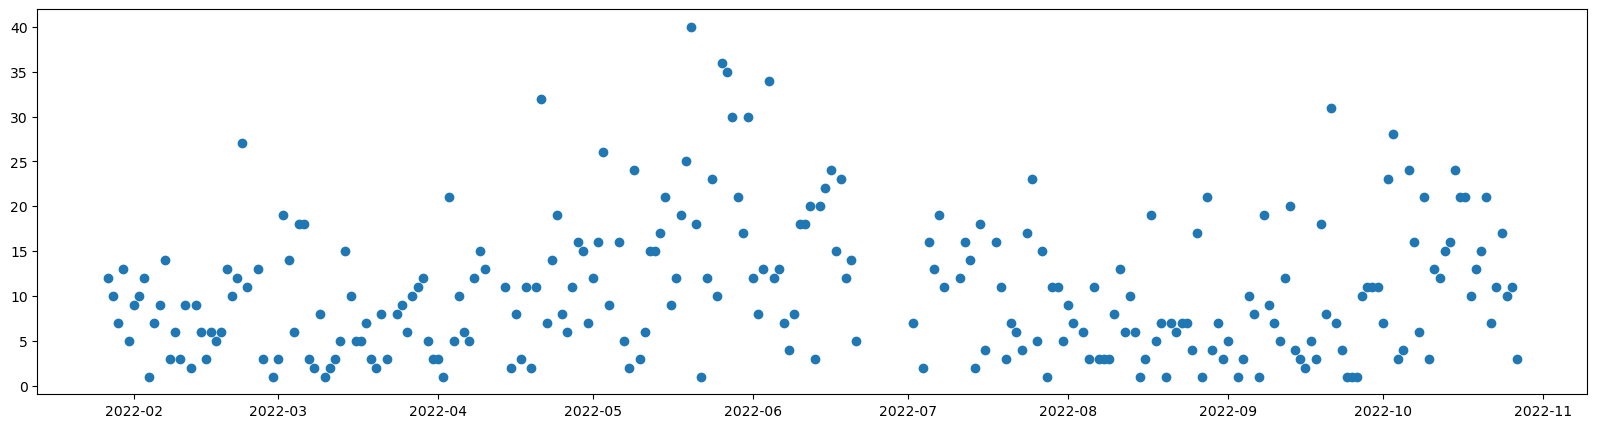

In [6]:
dates_count_group = df.groupby(by="Date", as_index=False).count()

plt.figure(figsize=(20,5))
plt.scatter(dates_count_group["Date"], dates_count_group["Tweets"])

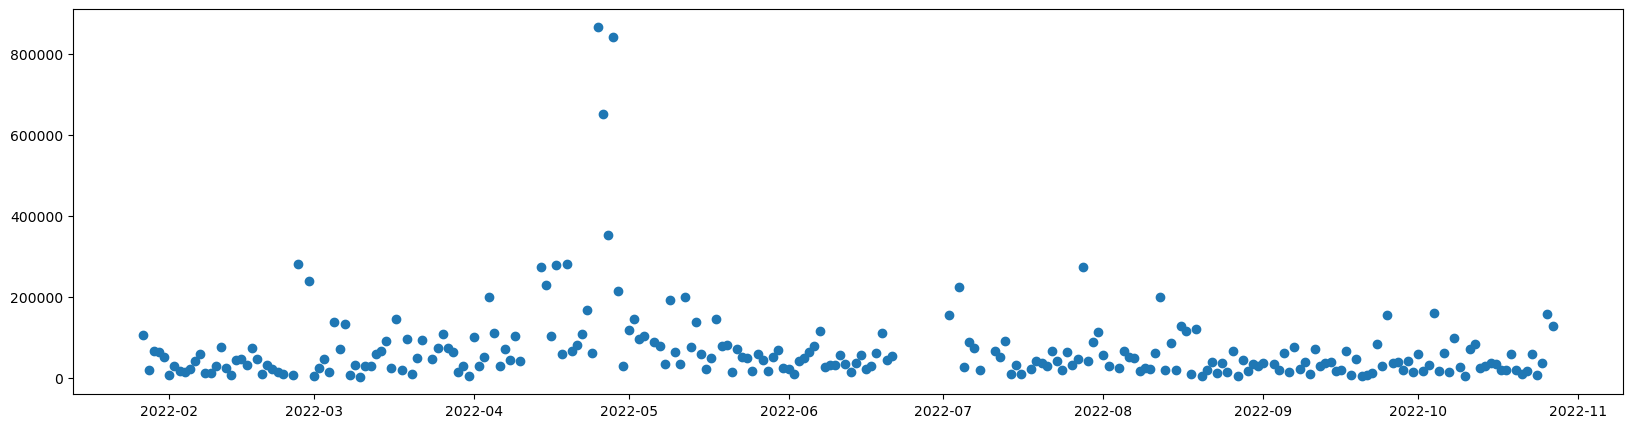

In [7]:
df_likes_to_tweets = dates_sum_group.copy()
df_likes_to_tweets["Tweets"] = dates_count_group["Tweets"]
df_likes_to_tweets["Likes/Tweets"] = df_likes_to_tweets.apply(lambda x: x["Likes"]/x["Tweets"], axis=1)


plt.figure(figsize=(20,5))
plt.scatter(df_likes_to_tweets["Date"], df_likes_to_tweets["Likes/Tweets"])

In [8]:
df[df["Date"] == dt(2022, 4, 28)]

,Tweets,Retweets,Likes,DateTime,Cleaned_Tweets,Date
1935,“Real magic is only a sip away.”\n(Actual slog...,20786,425103,2022-04-28 20:58:09,“Real magic is only a sip away.”(Actual slogan...,2022-04-28
1936,.@CocaCola Oh hi lol https://t.co/VhhVM9GzLJ,42793,625037,2022-04-28 20:53:49,. Oh hi lol,2022-04-28
1937,@BillyM2k Same,1497,64418,2022-04-28 20:42:02,Same,2022-04-28
1938,@walterkirn Freedom of speech means freedom of...,20619,271336,2022-04-28 17:36:09,Freedom of speech means freedom of speech,2022-04-28
1939,@scrowder Discomforting,4285,66614,2022-04-28 16:39:32,Discomforting,2022-04-28
1940,@DavidSacks @willcain Accurate interview,1254,27234,2022-04-28 10:11:41,Accurate interview,2022-04-28
1941,@WatcherGuru FCC FTW!,3419,64698,2022-04-28 07:23:14,FCC FTW!,2022-04-28
1942,@pmarca Sounds like satire,1720,37765,2022-04-28 04:48:15,Sounds like satire,2022-04-28
1943,@DrRamblings @BillyM2k Great show!,323,15196,2022-04-28 02:37:19,Great show!,2022-04-28
1944,@dogeofficialceo Trumpet is legit a way better...,2209,69642,2022-04-28 02:36:03,Trumpet is legit a way better name,2022-04-28


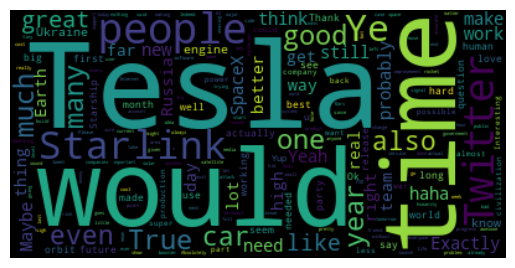

In [9]:
# Create stopword list:
stops = set(stopwords.words('english'))
stops.add("amp")
textt = " ".join(tweet for tweet in df["Cleaned_Tweets"])
wordcloud = WordCloud(stopwords=stops).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [16]:
True in [" ratio " in s for s in df["Tweets"].unique().tolist()]

True